In [71]:
import math
from mpmath import sinpi, cospi, pi
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [74]:
df = pd.read_excel(
    "https://gml.noaa.gov/grad/solcalc/NOAA_Solar_Calculations_year.xls",
    parse_dates=["Date"],
    skiprows=[366],
)

In [75]:
def unix2date(unix):
    dote = unix / 86400 + 719468
    cykl = (
        dote if dote >= 0
        else dote - 146096
    ) // 146097
    dotc = dote - cykl * 146097
    yotc = (dotc
        - dotc // 1460
        + dotc // 36524
        - dotc // 146096
    ) // 365
    return [
        int(yotc + cykl * 400),
        int(dotc - (yotc * 365
            + yotc // 4
            - yotc // 100))
    ]

In [76]:
df = pd.concat([
    df,
    pd.DataFrame(
        [unix2date(d.timestamp()) for d in df["Date"]],
        columns=["year", "doy"],
    ),
], axis=1).sort_values("doy").reset_index()

In [89]:
df["original"] = df["Eq of Time (minutes)"] / 14.4

In [90]:
df["radians"] = math.tau * (df.index + 5) / 365

In [91]:
df["yda"] = df.index + 0.5

In [92]:
df["toy"] = df["yda"] / 365

In [103]:
cospi(.5)

mpf('1.0')

In [125]:
costau = np.vectorize(lambda x: np.float64(cospi(2 * x)))

In [126]:
sintau = np.vectorize(lambda x: np.float64(sinpi(2 * x)))

In [127]:
costau([0, .25, .5, .75, 1])

array([ 1.,  0., -1.,  0.,  1.])

In [128]:
sintau([0, .25, .5, .75, 1])

array([ 0.,  1.,  0., -1.,  0.])

In [129]:
def model(toy, p0, p1, p2, p3, p4):
    return (
        p0 +
        p1 * costau(toy) +
        p2 * sintau(toy) +
        p3 * costau(2 * toy) +
        p4 * sintau(2 * toy)
    )

In [130]:
df["original"].max()

np.float64(1.1442262445226046)

In [131]:
#| label: eot
popt, pcov = curve_fit(model, df["toy"], df["original"])
dict(enumerate(popt.tolist()))

{0: 0.00014949317633417003,
 1: -0.4164553809136968,
 2: -0.2959657573651431,
 3: -0.46578504463469605,
 4: 0.5096179567359089}

In [135]:
df["fitted"] = [model(r, *popt) for r in df["toy"]]

In [136]:
df["fitted"].max()

np.float64(1.1399832338998561)

In [137]:
df["fitted"].min()

np.float64(-0.9837839258210404)

In [99]:
plotopts = {"linewidth": 3, "legend": True}

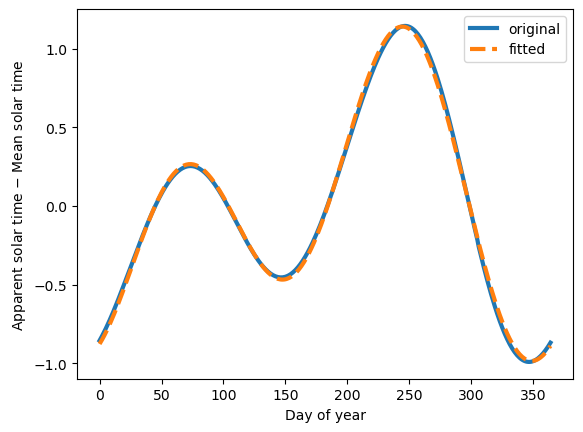

In [100]:
df["original"].plot(
    xlabel="Day of year",
    ylabel=r"Apparent solar time $-$ Mean solar time",
    **plotopts
)
df["fitted"].plot(linestyle="--", **plotopts);

In [138]:
df["original"] = df["Sun Declin (deg)"] * np.pi / 180

In [139]:
#| label: sda
popt, pcov = curve_fit(model, df["toy"], df["original"])
dict(enumerate(popt.tolist()))

{0: 0.006878449299022284,
 1: -0.14604479333954493,
 2: 0.3786874196695894,
 3: 0.0038625213245645435,
 4: 0.00562916502784165}

In [140]:
df["fitted"] = [model(r, *popt) for r in df["toy"]]

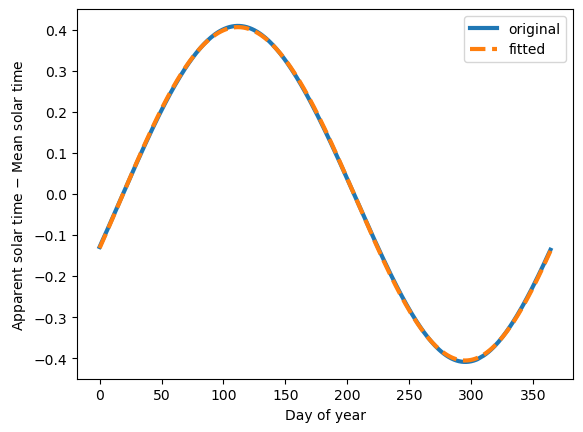

In [141]:
df["original"].plot(
    xlabel="Day of year",
    ylabel=r"Apparent solar time $-$ Mean solar time",
    **plotopts
)
df["fitted"].plot(linestyle="--", **plotopts);

In [142]:
sza = 90.833 * np.pi / 180

In [143]:
sza

1.5853349194640092

In [34]:
import numpy as np
from scipy.optimize import root_scalar

# coefficients
p0, p1, p2, p3, p4 = (
    1.4950424467725955e-05,
    -0.04189873301524992,
    -0.02923703633324393,
    -0.0456943801628261,
    0.05175601752530743
)

def f(gamma):
    return (p0 +
            p1*np.cos(gamma) +
            p2*np.sin(gamma) +
            p3*np.cos(2*gamma) +
            p4*np.sin(2*gamma))

def df(gamma):
    return (-p1*np.sin(gamma) +
            p2*np.cos(gamma) -
            2*p3*np.sin(2*gamma) +
            2*p4*np.cos(2*gamma))

# scan for roots of derivative
critical_points = []
grid = np.linspace(0, 2*np.pi, 1000)
sign_changes = np.where(np.sign(df(grid[:-1])) != np.sign(df(grid[1:])))[0]

for idx in sign_changes:
    bracket = (grid[idx], grid[idx+1])
    try:
        sol = root_scalar(df, bracket=bracket)
        if sol.converged:
            critical_points.append(sol.root)
    except:
        pass

# include boundaries
critical_points.extend([0, 2*np.pi])

# evaluate
values = [f(g) for g in critical_points]
fmin, fmax = min(values), max(values)

print("Min:", fmin)
print("Max:", fmax)

Min: -0.09837957051521798
Max: 0.11400512162142407
